# Fine-tuning a Decision Tree Model

In this notebook, we will load the Iris dataset, split it into training and test sets, and then fine-tune a Decision Tree classifier using GridSearchCV. We'll evaluate the performance of the best model using classification metrics and visualize the resulting decision tree.

## **Step 1: Load and Inspect the Data**

We use the Titanic dataset available from seaborn, which includes details about passengers. This dataset is widely used for classification tasks.

In [4]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Load Titanic dataset in seaborn
data = sns.load_dataset('titanic')

# Inspect the dataset
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### **Step 2: Data Preprocessing**

Our next step is to prepare the data for modeling:

- **Handling Missing Values:**
   Here, the line for dropping rows with missing 'age' is commented out.
   Depending on your needs, you might choose to drop these rows or use imputation.

- **Encoding Categorical Variables:**
   Decision tree algorithms can handle numerical inputs, so we convert
   categorical variables (e.g., `sex`) into numeric format using one-hot encoding.

*Note: We use drop_first=True to avoid the dummy variable trap.*

In [2]:
# Encoding categorical variables
df = pd.get_dummies(data, columns=['sex'], drop_first=True) # Use drop_first = True to avoid "dummy trap"

# Define features and target
features = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male']
X = df[features]
y = df['survived']

# Preview the cleaned dataset
print(X.head())
print(y.head())

   pclass   age  sibsp  parch     fare  sex_male
0       3  22.0      1      0   7.2500      True
1       1  38.0      1      0  71.2833     False
2       3  26.0      0      0   7.9250     False
3       1  35.0      1      0  53.1000     False
4       3  35.0      0      0   8.0500      True
0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64


### **Step 3: Splitting the Data**

We split the dataset into training and testing sets. The training set is used to build the decision tree model, while the testing set is used to evaluate its performance.

In [5]:
from sklearn.model_selection import train_test_split

# Split dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

### **Step 4: Fine-tuning the Decision Tree Model**

We'll perform hyperparameter tuning using GridSearchCV to find the best combination of parameters for the Decision Tree classifier. The parameters we will tune include:

- `criterion`: The algorithm used to optimize each split
- `max_depth`: Maximum depth of the tree
- `min_samples_split`: Minimum number of samples required to split an internal node
- `min_samples_leaf`: Minimum number of samples required to be at a leaf node

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_depth':[None, 2, 3, 4, 5, 6], 
    'min_samples_split':[2, 4, 6, 8], # can't do 1
    'min_samples_leaf': [1, 2, 3, 4]
}

# Initialize the Decision Tree classifier
dtree = DecisionTreeClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator = dtree,
                           param_grid = param_grid,
                           cv = 5,
                           scoring = 'accuracy')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Look at the best parameters and scores


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 4, 6, 8]},
             scoring='accuracy')

In [ ]:
grid_search.best_params_
# this combination of tree will give us the most accurate model possible

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

### **Step 5: Evaluate the Model**

Using the best estimator from the grid search, we will evaluate its performance on the test set by generating a classification report and confusion matrix.

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Get the best estimator
best_dtree = grid_search.best_estimator_

# Predict on the test set
y_pred = best_dtree.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# this is the best possible decision tree that we can build from our model

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

Confusion Matrix:
[[92 13]
 [23 51]]


### **Step 6: Visualizing the Decision Tree**

One of the advantages of decision trees is their interpretability. We can visualize the tree structure using the graphviz library.
The visualization shows:
- Splitting criteria at each node.
- Feature names used for splits.
- Class distributions within the nodes.

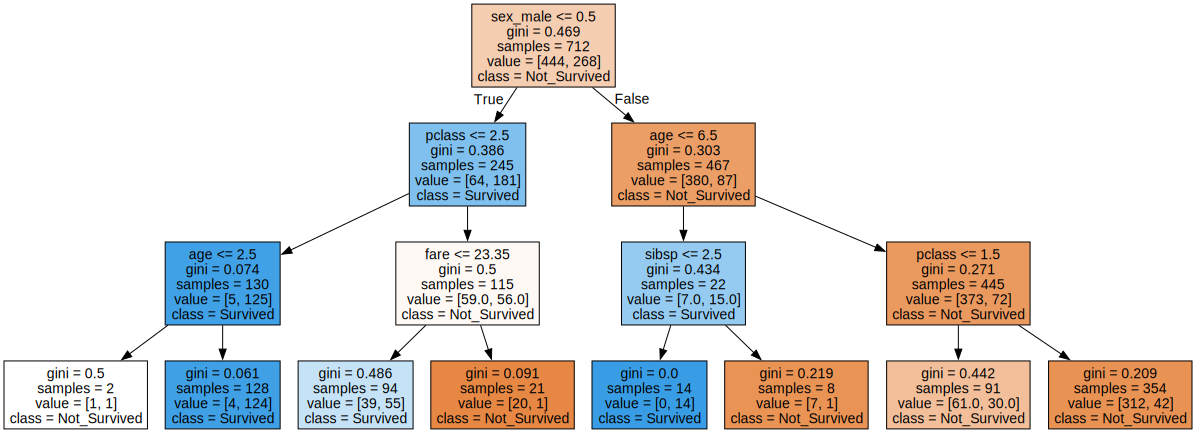

In [19]:
# Import graphviz and export the decision tree to dot format for visualization
import graphviz
from sklearn import tree  # Ensure to import the tree module from sklearn

dot_data = tree.export_graphviz(best_dtree,
                                feature_names=X_train.columns,
                                class_names=["Not_Survived", "Survived"],
                                filled=True)

# Generate and display the decision tree graph
graph = graphviz.Source(dot_data)
graph